In [ ]:
pip install dataframe-image

In [4]:
import csv
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sb
import networkx as nx
import dataframe_image as dfi
from BMotifs import Motifs

In [5]:
def motifs(df: pd.DataFrame, result: str):
    
        mat = df.to_numpy()
        p = Motifs(M = mat)
        p.count_motifs(range(1, 45))
        m_counts = p.motifs
        
        # Relative Frequencies
        if result == "rel_freq":
            x = m_counts["Motif"].values
            rel_freq = list(x) / sum(x)
            
            return rel_freq
        elif result == "counts":
            return m_counts

In [6]:
def shannon_entropy(a: np.array, n: int):
    
    entropy_value = sc.entropy(a, base = 2)
    max_entropy = np.log2(n)
    
    return entropy_value / max_entropy

In [7]:
def pearson_corr(x1: np.array, x2):

    if type(x2) != type(x1):
        x2 = np.array(x2)
        
    return list(sc.pearsonr(x1, x2))

In [8]:
def descr_stat(df: pd.DataFrame, var_name: str) -> pd.DataFrame:
    '''
    A function that calculates some elementary
    statistic metrics.
    
    Input: pandas DataFrame
    
    Output: pandas Dataframe w/ each statistic measure as a column
    '''
    # Creating the output dataframe
    stat_values = pd.DataFrame()
    
    # Variable names
    stat_values[var_name] = df.index.values
    
    # Arithmetic Average
    stat_values["Mean"] = df.mean(axis = 1, numeric_only = True)
    
    # Median
    stat_values["Median"] = df.median(axis = 1, numeric_only = True)
    
    # Standard Deviation
    stat_values["Standard Deviation"] = df.std(axis = 1, numeric_only = True)
    
    # Skewness
    stat_values["Skewness"] = df.skew(axis = 1, numeric_only = True)
    
    return stat_values

In [9]:
def total_var_dist(p, q):
    diff = np.abs(p - q)
    
    return 0.5 * np.sum(diff)   

In [33]:
def z_score(n_empirical, mean_null, stdev_null):
    return (n_empirical - mean_null) / stdev_null    

### Loading Data

In [10]:
# Loading the datasets
d_frames = []
folder_path = "data/"

glob_pattern = folder_path + "M_*" + ".csv"
csv_files = glob.glob(glob_pattern)
csv_files_sorted = sorted(csv_files)
for file in csv_files_sorted:
    dataset = pd.read_csv(file, index_col = 0)
    d_frames.append(dataset)
    
# Information about the networks 
info = pd.read_csv("data/references.csv")

# Including supplementary information regarding the area of the networks and habitat proximity
area = [190, 541, 13, 1692, 49, 243, 396, 229, 12, 13, 2147, 2079]
habit_prox = [73.4, 28.3, 331, 26.5, 0.2, 44.6, 1772.8, 73.6, 
              112.7, 104.3, 1783.1, 1731.8]

info["Area(ha)"], info["Habitat Proximity(ha)"] = area, habit_prox

### Creating the Networks

In [ ]:
# Generating an empty network list
empty_nets = []
for i in range(0, 12):
    G = nx.Graph()
    empty_nets.append(G)
    
# Generating the pollination networks
net_list = {}
counter = 1

for j, k in zip(d_frames, empty_nets):
    k.add_nodes_from(j.index, bipartite = 0)
    k.add_nodes_from(j.columns, bipartite = 1)

    for row in j.index:
        for col in j.columns:
            if j.loc[row, col] == 1:
                k.add_edge(row, col)
                
    net_list.update({"Net {}".format(counter): k})
    counter += 1

### Motifs and Entropy

In [11]:
# Calculation of Motif Occurrences
motifs_rel_freq = {
    "Motif ID": [_ for _ in range(1, 45)]
}

for i, df in enumerate(d_frames):
    calculation = motifs(df, "rel_freq")
    element = {"Net {}".format(i + 1): calculation}
    motifs_rel_freq.update(element)

df_motifs_rf = pd.DataFrame(motifs_rel_freq)

In [12]:
# Entropy Calculation
names = ["Net {}".format(i) for i in range(1, 13)]
entropies = pd.DataFrame({
    "Network Identifier": names,
    "Entropy": [shannon_entropy(df_motifs_rf[_].values, 44) for _ in names]
})

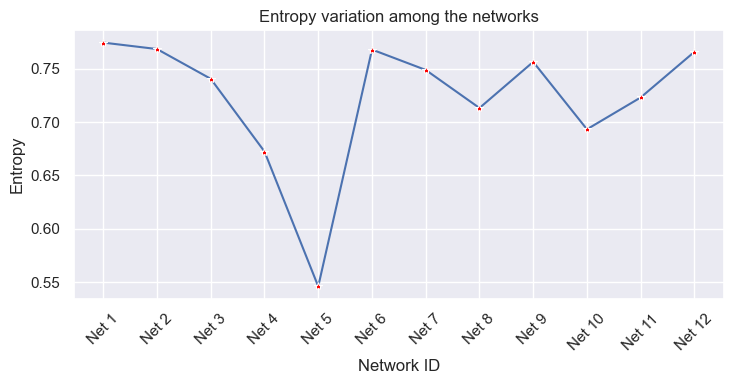

In [13]:
# Visualizing entropy variation
sb.set(rc={'figure.figsize':(7.5, 4)})
plt.figure()
plot_sb = sb.lineplot(x="Network Identifier", y="Entropy", data = entropies, 
            marker='*', markerfacecolor='red')
plt.xlabel("Network ID")
plt.ylabel("Entropy")
plt.title("Entropy variation among the networks")

plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

figure = plot_sb.get_figure()    
#figure.savefig('Entropy Variation.png', dpi=400)

### Correlations with Ecological Variables

In [14]:
floral_abd = []
for _ in d_frames:
    x = len(_.index)
    floral_abd.append(x)
# Deleting the values of Difuntito protected area
dif_index = 2
del area[dif_index]
del habit_prox[dif_index]
del floral_abd[dif_index]
entropies_values = entropies["Entropy"].values
entropies_values = np.delete(entropies_values, dif_index)
connectance = info["Connectance"].values
connectance = np.delete(connectance, dif_index)

In [15]:
# List of ecological variables
ecol_var = [floral_abd, area, habit_prox, connectance]
variables = ["Floral Abundance", "Habitat area (ha)", "Habitat proximity (ha)", "Connectance"]

df_entropies = pd.DataFrame({
    "Variable": variables,
    "Statistic": [pearson_corr(entropies_values, i)[0] for i in ecol_var],
    "p-value": [pearson_corr(entropies_values, j)[1] for j in ecol_var]
})

In [16]:
# Investigating the correlation of the Ecological Variables with Nestedness and Modularity
nest = [5.073, 5.726, 5.514, 8.642, 8.299, 4.834, 10.152, 5.318, 5.134, 10.696, 7.431, 5.656]
mod = [0.459, 0.466, 0.424 ,0.412 ,0.424, 0.448, 0.394, 0.418, 0.449, 0.442, 0.391, 0.414]

del nest[dif_index]
del mod[dif_index]

nest = np.array(nest)
mod = np.array(mod)

df_nest = pd.DataFrame({
    "Variable": variables, 
    "Statistic": [pearson_corr(nest, i)[0] for i in ecol_var],
    "p-value": [pearson_corr(nest, j)[1] for j in ecol_var]
})

df_mod = pd.DataFrame({
    "Variable": variables, 
    "Statistic": [pearson_corr(mod, i)[0] for i in ecol_var],
    "p-value": [pearson_corr(mod, j)[1] for j in ecol_var]
})

In [17]:
# Correlation matrix
correlation_matrix = pd.DataFrame({
    "Variable": variables,
    "Entropy": df_entropies["Statistic"].values,
    "Nestedness": df_nest["Statistic"].values,
    "Modularity": df_mod["Statistic"].values
})
correlation_matrix.set_index("Variable", inplace = True)

In [18]:
# p-value matrix
pval_matrix = pd.DataFrame({
    "Variable": variables,
    "Entropy": df_entropies["p-value"].values,
    "Nestedness": df_nest["p-value"].values,
    "Modularity": df_mod["p-value"].values
})
pval_matrix.set_index("Variable", inplace = True)

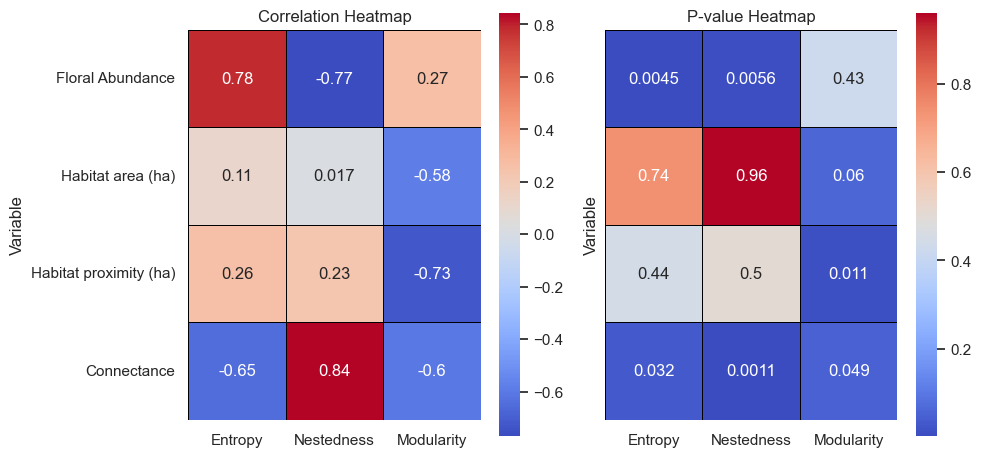

In [19]:
# Visualizing correlations and p-values
fig, axes = plt.subplots(1, 2, figsize = (10, 6))

# Correlation
sb.heatmap(correlation_matrix, annot = True, cmap='coolwarm', 
            linewidths=0.5, linecolor='black', cbar=True, square=True, ax=axes[0], cbar_kws={"shrink": 0.75})
axes[0].set_title('Correlation Heatmap')

# p-values
sb.heatmap(pval_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black', 
           cbar=True, square=True, ax=axes[1], cbar_kws={"shrink": 0.75}, yticklabels = False)
axes[1].set_title('P-value Heatmap')

plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
#plt.savefig("Heatmap.png")
plt.show()

### Summary Statistics

In [20]:
# Removing Difuntito network
df_motifs_rf.drop(columns = "Net 3", inplace = True)

In [21]:
df_motifs_rf.set_index("Motif ID", inplace = True)

In [22]:
stat_measures = descr_stat(df_motifs_rf, "Motif ID")
stat_measures.set_index("Motif ID", inplace = True)

In [23]:
# Most Overpresented Motifs -> table for latex
top_10 = stat_measures.nlargest(n=10, columns='Mean')
print(top_10.style.to_latex())

\begin{tabular}{lrrrr}
 & Mean & Median & Standard Deviation & Skewness \\
Motif ID &  &  &  &  \\
39 & 0.179925 & 0.188754 & 0.034410 & -0.609505 \\
40 & 0.118457 & 0.110292 & 0.022941 & 0.372079 \\
26 & 0.076246 & 0.080297 & 0.032650 & -0.345222 \\
28 & 0.052474 & 0.054533 & 0.024492 & -0.027278 \\
41 & 0.051037 & 0.052286 & 0.013726 & -0.524593 \\
20 & 0.044471 & 0.034683 & 0.039476 & 0.854004 \\
30 & 0.042352 & 0.046915 & 0.012299 & -1.340439 \\
27 & 0.040591 & 0.041884 & 0.010990 & -1.595761 \\
29 & 0.031516 & 0.030602 & 0.013316 & 0.371791 \\
14 & 0.030235 & 0.029151 & 0.004363 & -0.243416 \\
\end{tabular}



### Total Variation Distance

In [24]:
total_var = []
for i in range(len(df_motifs_rf.columns)):
    for j in range(i+1, len(df_motifs_rf.columns)):
        a, b = df_motifs_rf.iloc[:, i].values, df_motifs_rf.iloc[:, j].values
        tvd = total_var_dist(a, b)
        total_var.append(tvd)

###### 1) Correlation with common species

In [25]:
# Matched Species : the key in the dictionaries corresponds to the two networks that are being compared
pollinators = {}
plants = {}

for i in range(0, len(d_frames) - 1):
    for j in range(i+1, len(d_frames)):
        # Common pollinators
        common_poll = set(d_frames[i].columns)
        pollinators.update({"{}-{}".format(i+1, j+1): [x for x in d_frames[j].columns if x in common_poll]})
        # Common plants
        common_plants = list(d_frames[i].index.intersection(d_frames[j].index))
        plants.update({"{}-{}".format(i+1, j+1): common_plants}) 
        
# Data frames of common pollinators and plants
pollinators_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in pollinators.items() ]))
plants_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in plants.items() ]))

In [26]:
# Number of common species
poll_no = []
plant_no = []

for key in pollinators:
    poll_no.append(len(pollinators[key]))

for key in plants:
    plant_no.append(len(plants[key]))
    
common_sp = [x + y for x, y in zip(poll_no, plant_no)]

In [27]:
combinations = list(pollinators_df.columns.values)

In [28]:
# Data Frame that contains number of common species for each network combination
common = {
    "Combination": combinations,
    "Common Sp": common_sp,
    "Common Poll": poll_no,
    "Common Plants": plant_no
}
df_common = pd.DataFrame(common)
df_common.set_index("Combination", inplace = True)

# Removing Difuntito
for _ in df_common.index.values:
    if "3" in _:
        df_common.drop(_, inplace = True)

###### 2) Correlation with common links

In [29]:
# Finding common links
common_edges_df = pd.DataFrame(columns=['Pair', 'Percentage of Common Edges']) 

for i in range(len(net_list)):
    for j in range(i + 1, len(net_list)):
        edges1 = set(net_list["Net {}".format(i+1)].edges())
        edges2 = set(net_list["Net {}".format(j+1)].edges())
        
        common_edges = edges1.intersection(edges2)
        denominator = len(edges1.union(edges2))
        percentage = (len(common_edges) / denominator)
        pair = f"{i+1}-{j+1}"
        common_edges_df = common_edges_df.append({'Pair': pair, 
                                                  'Percentage of Common Edges': percentage}, ignore_index=True)
common_edges_df.set_index("Pair", inplace = True)

NameError: name 'net_list' is not defined

In [ ]:
# Removing Difuntito
for _ in common_edges_df.index.values:
    if "3" in _:
        common_edges_df.drop(_, inplace = True)

In [ ]:
df_common["Common Links"] = common_edges_df["Percentage of Common Edges"].values
df_common["TVD"] = total_var

In [ ]:
# Correlation and p-values for TVD
var_corr = [df_common.iloc[:, i] for i in range(4)]
df_tvd = pd.DataFrame({
    "Variable": df_common.columns[0:-1], 
    "Statistic": [pearson_corr(total_var, i)[0] for i in var_corr],
    "p-value": [pearson_corr(total_var, j)[1] for j in var_corr]
})

In [ ]:
df_tvd

In [ ]:
# Barplot for correlation and p-values
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(8, 4))

# Define the x-axis positions for the bars
x = ["Species", "Pollinators", "Plants", "Links"]

# Set the width of each bar
width = 0.35

# Create the first bar plot
ax1.bar(x, df_tvd["Statistic"], width, color='blue')
ax1.set_title('Pearson Correlation')
ax1.set_xlabel('Common Variable')
ax1.set_ylabel('Value')

# Create the second bar plot
ax2.bar(x, df_tvd["p-value"], width, color='red')
ax2.set_title('P-value')
ax2.set_xlabel('Common Variable')
ax2.set_ylabel('Value')

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig("Corr-p Barplot.png")
plt.show()

### Null Models

In [30]:
# Generating null models and counting the motifs for each one
metrics_df = [] 
NUM = 100 # number of randomizations

for i in range(len(d_frames)):
    # Specify path of the folder
    path = "/home/kostasan00/Documents/Master Projects/Scripts/Null Models/Net {}/".format(i+1)
    # Data Frame that stores the motifs for each model
    null_df = pd.DataFrame({"Motif ID": np.arange(1, 45)})
    # Reading the null model files
    for j in range(NUM):
        model = pd.read_csv(path + "Model_{}.csv".format(j+1))
        motif_counts = motifs(model, "counts")
        null_df["Model {}".format(j+1)] = motif_counts["Motif"].values
    # Statistic measures of motifs
    stat_value = descr_stat(null_df, "Motif ID")
    metrics_df.append(stat_value)

/tmp/ipykernel_9655/3150799991.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  null_df["Model {}".format(j+1)] = motif_counts["Motif"].values
/tmp/ipykernel_9655/3150799991.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  null_df["Model {}".format(j+1)] = motif_counts["Motif"].values
/tmp/ipykernel_9655/3150799991.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [31]:
# Motif Counts of Empirical Networks
counts_empirical = []
for i in range(len(d_frames)):    
    count_motifs = motifs(d_frames[i], "counts")
    counts_empirical.append(count_motifs)

In [32]:
# Removing Difuntito
del counts_empirical[dif_index]
del metrics_df[dif_index]

In [34]:
# Calculating z-scores
z_score_df = pd.DataFrame({
    "Motif ID": np.arange(1, 45)
})

for i in range(0, 11):
    z_score_df["Z-score: {}".format(i+1)] = [z_score(counts_empirical[i].iloc[_, 1],
                                                     metrics_df[i].iloc[_, 1],
                                                     metrics_df[i].iloc[_, 3]) for _ in range(0, 44)]        

In [39]:
# Saving Z-scores data frame
z_score_df.to_csv("z-scores.csv")

In [ ]:
# Exporting table as a png image
z_score_df.set_index("Motif ID", inplace = True)
dfi.export(z_score_df, 'Z-scores.png', table_conversion = "matplotlib")